In [30]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cartopy.feature as cfeature
import os
import matplotlib.ticker as mticker
import healpy as hp

import cartopy
from ulmo.analysis.spatial_plots import evals_to_healpix, evals_to_healpix_stat, show_med_LL

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# this is going to be my Healpy images

ImportError: cannot import name 'LongitudeFormatter' from 'matplotlib.ticker' (/opt/conda/lib/python3.10/site-packages/matplotlib/ticker.py)

In [2]:
aug10 = xarray.open_dataset('/home/jovyan/20120810120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')
analysis_table = pandas.read_parquet('/home/jovyan/SST_L3S_VIIRS_2012.parquet')

In [5]:
eval_tbl = analysis_table
nside = 64
hpma, hp_lons, hp_lats, hp_values = evals_to_healpix_stat(eval_tbl, nside, metric = 'mean_temperature', stat = 'mean')

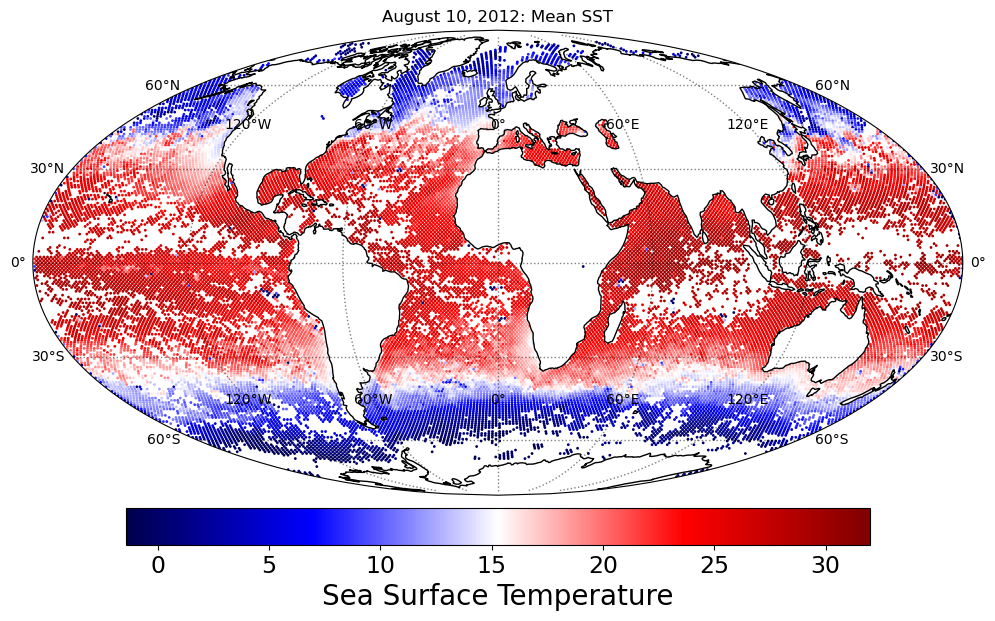

In [11]:
fig = plt.figure(figsize=(12,8))
color='seismic'
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)

cm = plt.get_cmap(color)
good = np.invert(hp_values.mask)
img = plt.scatter(x=hp_lons[good],
    y=hp_lats[good],
    c=hp_values[good],  
    cmap=cm,
    s=1,
    transform=tformP)

cb = plt.colorbar(img, orientation='horizontal', pad=0.02, shrink = 0.8)
clbl = 'Sea Surface Temperature'
cb.set_label(clbl, fontsize=20.)
cb.ax.tick_params(labelsize=17)
ax.coastlines(zorder=10)
ax.set_global()
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1,
                  color='black', alpha=0.5, linestyle=':', draw_labels=True)

gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}
plt.title("August 10, 2012: Mean SST")

plt.show()

#save_dir = os.path.expanduser('~/plots')
#save_filename = os.path.join(save_dir, 'plot1.png')

#plt.savefig(save_filename, dpi=300, bbox_inches='tight')
#plt.close(fig)

In [17]:
# plot number of cutouts per healpy cell

hpma, hp_lons, hp_lats, hp_values = evals_to_healpix_stat(eval_tbl, nside, metric='mean_temperature', stat='mean')
num_cutouts = np.sum(~hp_values.mask, axis=0)
num_cutouts = np.sum(~hp_values.mask, axis=0)

In [22]:
hp_values[np.invert(hp_values.mask)]
# the sum needs be calcuated in the evals_to_healpix_stat method somehow, because it is producing a mean and I want it to produce a sum

masked_array(data=[-0.21938493847846985, 1.1147021055221558,
                   0.25700806826353073, ..., -0.19610036696706498,
                   -0.0250173881649971, -0.1687394641339779],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-1.6375e+30)

/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  result = super().scatter(*args, **kwargs)


NameError: name 'LongitudeFormatter' is not defined

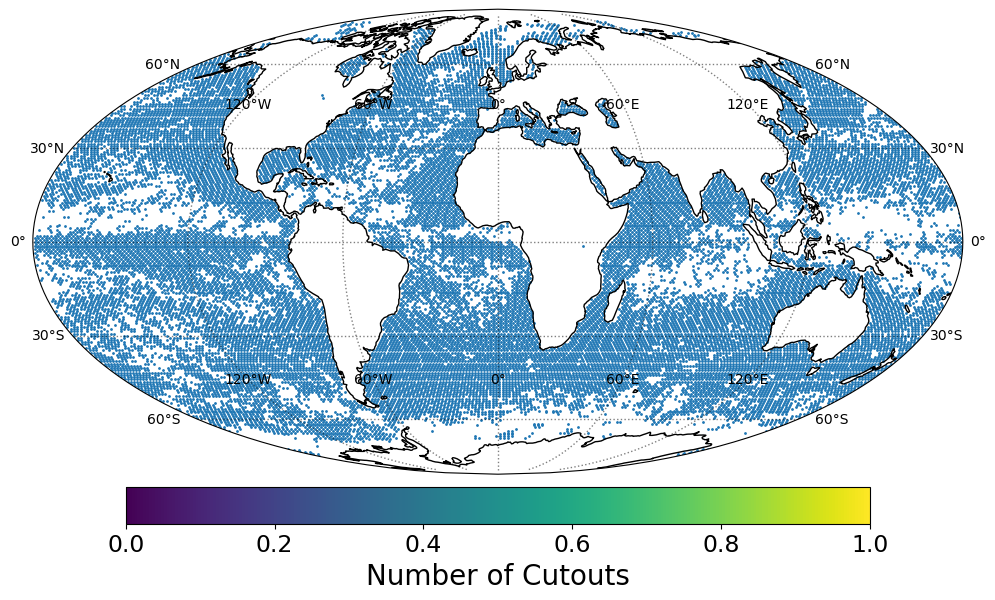

In [20]:
fig = plt.figure(figsize=(12, 8))
color = 'seismic'
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)
cm = plt.get_cmap(color)
norm = plt.Normalize(vmin=np.min(num_cutouts), vmax=np.max(num_cutouts))

good = np.invert(hp_values.mask)
img = plt.scatter(
    x=hp_lons[good],
    y=hp_lats[good],
    c=num_cutouts[good],
    cmap=cm,
    s=1,
    norm=norm,
    transform=tformP)

cb = plt.colorbar(img, orientation='horizontal', pad=0.02, shrink=0.8)
clbl = 'Number of Cutouts'
cb.set_label(clbl, fontsize=20.)
cb.ax.tick_params(labelsize=17)

ax.coastlines(zorder=10)
ax.set_global()

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1,
                color='black', alpha=0.5, linestyle=':', draw_labels=True)

gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}

plt.title("August 10, 2012: Mean SST")

plt.show()

In [28]:
lats = eval_tbl.lat.values
lons = eval_tbl.lon.values

theta = (90 - lats) * np.pi / 180.  # convert into radians
phi = lons * np.pi / 180.
idx_all = hp.pixelfunc.ang2pix(nside, theta, phi)

npix_hp = hp.nside2npix(nside)
all_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int'))  # array of all pixels on map
metric_values = np.ma.masked_array(np.zeros(npix_hp, dtype='float'))  # will contain summed metric value in each pixel

for i, idx in enumerate(idx_all):
    all_events[idx] += 1  # pixels concentrated with data pts >= 1 ; those without data remain 0

zero = all_events == 0
float_events = all_events.astype(float)

pixels = np.unique(idx_all)
for pixel in pixels:
    good = pixel == idx_all
    sub_vals = good.sum()
    metric_values[pixel] = np.sum(sub_vals)

evts = hp.ma(float_events)
metrics = hp.ma(metric_values)
evts.mask = zero
metrics.mask = zero

hp_lons, hp_lats = hp.pixelfunc.pix2ang(nside, np.arange(npix_hp), lonlat=True)

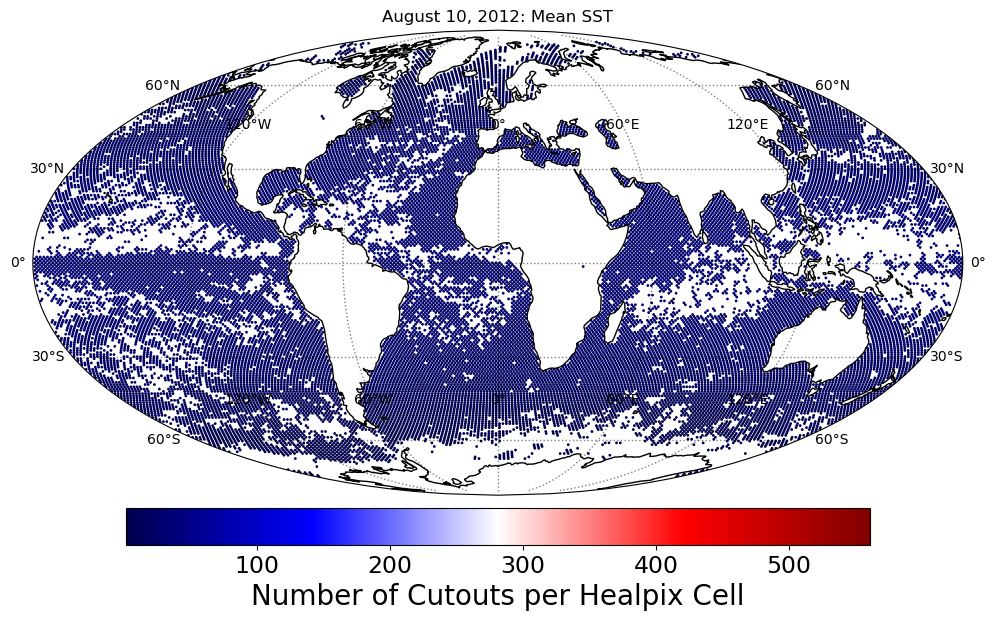

In [37]:
fig = plt.figure(figsize=(12, 8))
color = 'seismic'
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)

# Map the number of cutouts to a colormap
cm = plt.get_cmap(color)
#norm = plt.Normalize(vmin=np.min(metrics), vmax=np.max(metrics))

# Plot Healpy map
#good = np.invert(hp_values.mask)
img = plt.scatter(
    x=hp_lons[good],
    y=hp_lats[good],
    c=hp_values[good],
    cmap=cm,
    s=1,
    norm=norm,
    transform=tformP
)

cb = plt.colorbar(img, orientation='horizontal', pad=0.02, shrink = 0.8)
clbl = 'Number of Cutouts per Healpix Cell'
cb.set_label(clbl, fontsize=20.)
cb.ax.tick_params(labelsize=17)
ax.coastlines(zorder=10)
ax.set_global()
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1,
                  color='black', alpha=0.5, linestyle=':', draw_labels=True)

gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}
plt.title("August 10, 2012: Mean SST")

plt.show()

# something is wrong with the creation of the mask???